In [54]:
from sympy import Eq, symbols, Matrix, solve, expand, simplify, trigsimp, powsimp
from sympy.matrices import *
from sympy.solvers.solveset import linear_eq_to_matrix
from sympy.physics.mechanics import *
from sympy.physics.vector import vlatex

mechanics_printing()

symbol_names = 'theta phi_1 phi_2 v_x v_z omega_0 omega_1 omega_2'
q3, q4, q5, u1, u2, u3, u4, u5 = dynamicsymbols(symbol_names)
q3d, q4d, q5d, u1d, u2d, u3d, u4d, u5d = dynamicsymbols(symbol_names, 1)
q3dd, q4dd, q5dd = dynamicsymbols('theta phi_1 phi_2', 2)

M, f1, f2, f3, F, d, f = dynamicsymbols('M, f_1, f_2, f_3, F, delta, f')
ax, az, T = symbols('a_x a_z T')

h, I, m, k = symbols('h I m k')

N = ReferenceFrame('N')
A = N.orientnew('A', 'Space', [0, q3, 0], '321')
A.set_ang_vel(N,u3*A.y)

B = A.orientnew('B', 'Space', [0, q4, 0], '321')
B.set_ang_vel(A,u4*A.y)

C = B.orientnew('C', 'Space', [0, q5, 0], '321')
C.set_ang_vel(B,u5*A.y)

O = Point('O')
O.set_vel(N, 0)

CM1 = Point('CM1')
CM1.set_vel(A,0)
CM1.set_vel(N,u1*A.x + u2*A.z)

P0 = CM1.locatenew('P0', -(h/2)*A.x)
P0.v2pt_theory(CM1,N,A)

P1 = CM1.locatenew('P1', (h/2)*A.x)
P1.v2pt_theory(CM1,N,A)

CM2 = P1.locatenew('CM2', (h/2)*B.x)
CM2.v2pt_theory(P1,N,B)

P2 = CM2.locatenew('P2', (h/2)*B.x)
P2.v2pt_theory(CM2,N,B)

CM3 = P2.locatenew('CM3', (h/2)*C.x)
CM3.v2pt_theory(P2,N,C)

P3 = CM3.locatenew('P3', (h/2)*C.x)
P3.v2pt_theory(CM3,N,C)

I1 = inertia(A, 0, I, 0)
I2 = inertia(B, 0, I, 0)
I3 = inertia(C, 0, I, 0)

ForceList = [(P0, T*A.x + T*d*A.z), (P1, f1*A.z), (P2, f2*B.z), (P3, f3*C.z), (A, (M+k*q4)*A.y), (B, -k*(q4-q5)*A.y), (C, -k*q5*A.y)]

Body1 = RigidBody('Body1', CM1, A, m, (I1, CM1))
Body2 = RigidBody('Body2', CM2, B, m, (I2, CM2))
Body3 = RigidBody('Body3', CM3, C, m, (I3, CM3))

BodyList = [Body1, Body2, Body3]

KM = KanesMethod(N, q_ind=[q3, q4, q5], u_ind=[u1, u2, u3, u4, u5], kd_eqs = [q3d-u3, q4d-u4, q5d-u5])
(fr, frstar) = KM.kanes_equations(ForceList, BodyList)
EOM = fr+frstar

In [55]:
u1dsub=solve(ax-dot(CM1.acc(N),A.x),u1d)[0]
u2dsub=solve(az-dot(CM1.acc(N),A.z),u2d)[0]
EOMa = expand(EOM).subs([(u1d,u1dsub),(u2d,u2dsub)])

axsub=solve(EOMa[0],ax)[0]
azsub=solve(EOMa[1],az)[0]             
EOMr = EOMa[2:5,0].subs([(ax,axsub),(az,azsub)])

#input_eq = [f1 - T*d, f2, f3-f, M -T*d*h/2]
#Emat1, Emat2 = linear_eq_to_matrix(input_eq,[M, f1, f2, f3])
#Emat, dum = linear_eq_to_matrix(Emat2,[f, d])
#E = Emat1.inv()*Emat

from sympy import acos
y = dynamicsymbols('y')
output = acos(dot(A.x,N.x))
#output = acos(dot(B.x,N.x))
#output = acos(dot(C.x,N.x))

In [56]:
op_point = {q3: 0, u3: 0, q4: 0, u4: 0, q5: 0, u5: 0}
EOMr.expand
f_0 = [q3d,q4d,q5d]
f_1 = [-u3,-u4,-u5]
Mmat ,Bmat = linear_eq_to_matrix(expand(EOMr),[u3d,u4d,u5d])
Mmat = -Mmat
f_2 = Mmat*Matrix([[u3d],[u4d],[u5d]])
f_3 = Bmat       
f_4 = [0,0,0]
f_c = []
f_v = []
f_a = []
q = [q3,q4,q5]
u = [u3,u4,u5]
q_i= [q3,q4,q5]
u_i= [u3,u4,u5]
r= [d,f1,f2,f3]

L = Linearizer(f_0, f_1, f_2, f_3, f_4, f_c, f_v, f_a, q, u, q_i=q_i, u_i=u_i, r=r)

#L = KM.to_linearizer()
Mm, Am, Bm = L.linearize(op_point=op_point, simplify=True)
EOMlin = Mm*Matrix([L._qd,L._ud]) - Am*Matrix([L.q,L.u]) - Bm*L.r

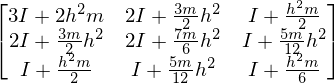

In [57]:
Mm[3:6,3:6]

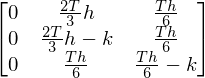

In [58]:
Am[3:6,0:3]

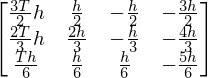

In [59]:
Bm[3:6,:]

In [65]:
fi = open('eqM.tex','w')
fi.write(vlatex(Mm[3:6,3:6]))
fi.write(vlatex(Matrix([[q3dd],[q4dd],[q5dd]])))
fi.write(' + ')
fi.write(vlatex(simplify(-Am[3:6,0:3])))
fi.write(vlatex(Matrix([[q3],[q4],[q5]])))
fi.write(' = ')
fi.write(vlatex(Bm[3:6,:]))
fi.write(vlatex(Matrix([d,f1,f2,f3])))
fi.close()

In [61]:
from sympy import trigsimp
simplify(trigsimp(output))

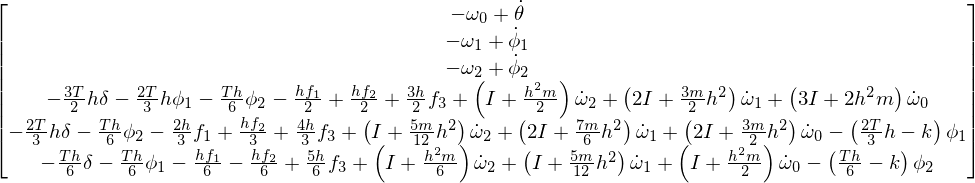

In [62]:
EOMlin